In [1]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import  preprocess_input

2024-06-18 15:04:26.269424: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-18 15:04:26.876232: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 15:04:26.876275: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 15:04:26.982394: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-18 15:04:27.208716: I tensorflow/core/platform/cpu_feature_guar

In [52]:
src_path_train = "./Data_pet_CT/train/"
src_path_valid = "./Data_pet_CT/valid/"
src_path_test = "./Data_pet_CT/test/"

scale=1
rotation=20
# zoom=0.25
width_shift=0.25
height_shift=0.25
shear=0.25

train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        dtype='float32',
        rescale=scale,
        rotation_range=rotation,
        # zoom_range=zoom,
        width_shift_range=width_shift,
        height_shift_range=width_shift,
        shear_range=shear,
        horizontal_flip=True)

valid_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,    
        dtype='float32',
        rescale=scale,) 

test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        dtype='float32',
        rescale=scale,)

In [48]:
BATCH_SIZE = 32
train_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_directory(
    directory=src_path_valid,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    directory=src_path_test,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 1099 images belonging to 4 classes.
Found 270 images belonging to 4 classes.
Found 139 images belonging to 4 classes.


In [4]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout

In [5]:
NUM_CLASSES = 4

CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
HIDDEN_LAYER_ACTIVATION = 'relu'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

LOSS_METRICS = ['accuracy']

NUM_EPOCHS = 50
EARLY_STOP_PATIENCE = 10

BATCH_SIZE_TESTING = 1
STEPS_PER_EPOCH_TRAINING = int(train_generator.n / BATCH_SIZE) + 1
STEPS_PER_EPOCH_VALIDATION = int(valid_generator.n / BATCH_SIZE) + 1

In [32]:
model = Sequential()

model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))
model.add(Flatten())
model.add(BatchNormalization())


# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
# model.add(Dense(512, activation = HIDDEN_LAYER_ACTIVATION))
# model.add(Dense(256, activation = HIDDEN_LAYER_ACTIVATION))
model.add(Dense(128, activation = HIDDEN_LAYER_ACTIVATION))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))
# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

In [33]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_3 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 516       
                                                      

In [109]:
from tensorflow.keras import optimizers

sgd = optimizers.SGD(learning_rate = 0.01, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [35]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = './models/3_Subclass_Cancer/model.hdf5', monitor = 'val_loss', save_best_only = False, mode = 'auto')

In [36]:
fit_history = model.fit(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=valid_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[
            # cb_early_stopper, 
            cb_checkpointer]
)

Epoch 1/50
35/35 [==============================] - 13s 300ms/step - loss: 1.1134 - accuracy: 0.6133 - val_loss: 0.6282 - val_accuracy: 0.6889
Epoch 2/50
35/35 [==============================] - 10s 291ms/step - loss: 0.5693 - accuracy: 0.7807 - val_loss: 0.4650 - val_accuracy: 0.8074
Epoch 3/50
35/35 [==============================] - 10s 290ms/step - loss: 0.4398 - accuracy: 0.8280 - val_loss: 0.4759 - val_accuracy: 0.7852
Epoch 4/50
35/35 [==============================] - 10s 293ms/step - loss: 0.3649 - accuracy: 0.8562 - val_loss: 0.2894 - val_accuracy: 0.8963
Epoch 5/50
35/35 [==============================] - 10s 282ms/step - loss: 0.3301 - accuracy: 0.8753 - val_loss: 0.2873 - val_accuracy: 0.8815
Epoch 6/50
35/35 [==============================] - 10s 280ms/step - loss: 0.3074 - accuracy: 0.8763 - val_loss: 0.2460 - val_accuracy: 0.9111
Epoch 7/50
35/35 [==============================] - 10s 276ms/step - loss: 0.3183 - accuracy: 0.8772 - val_loss: 0.2236 - val_accuracy: 0.8926

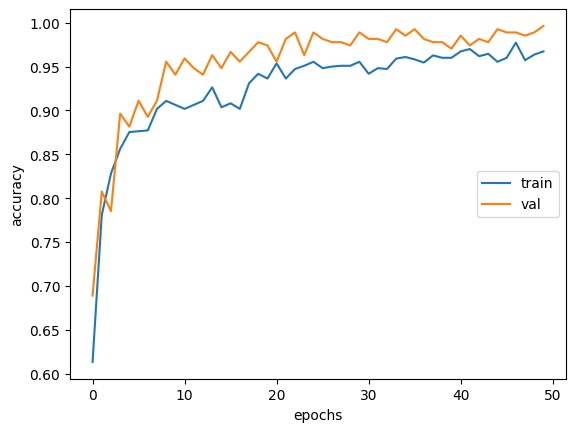

In [37]:
import matplotlib.pyplot as plt
plt.plot(fit_history.history['accuracy'], label = 'train',)
plt.plot(fit_history.history['val_accuracy'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

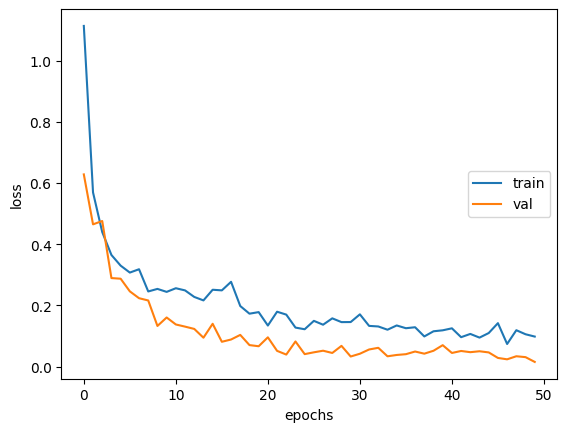

In [38]:
plt.plot(fit_history.history['loss'], label = 'train',)
plt.plot(fit_history.history['val_loss'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [39]:
# model.load_weights(filepath='./models/best.hdf5')
model.evaluate(test_generator)

139/139 [==============================] - 3s 17ms/step - loss: 0.0542 - accuracy: 0.9784


[0.05420289188623428, 0.9784172773361206]